In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/val.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/train.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/test.zip -d data

In [57]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

train_transform = T.Compose([
  T.RandomResizedCrop(size=256),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])

test_transform = T.Compose([
  T.Resize([256, 256]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])


val_transform = T.Compose([
  T.Resize([256, 256]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])


train_dataset = ImageFolder('data/train', train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder('data/test', test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

val_dataset = ImageFolder('data/val', val_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [50]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [45]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def create_model(n_classes):
  model = models.resnet18(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [5]:
from torchvision import models
from torch import nn, optim
from tqdm import tqdm

model = create_model(1)

In [279]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in tqdm(data_loader):
    inputs = inputs.to(device)
    labels = labels.unsqueeze(1).to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    y_pred = torch.round(torch.sigmoid(outputs))
    correct_predictions += torch.sum(y_pred == labels)


  return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
from torch import optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCEWithLogitsLoss()

n_epochs = 1
writer = SummaryWriter()
for epoch in range(n_epochs):
  print(f'\n[Epoch {epoch + 1}/{n_epochs}]\n')

  train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, len(train_dataset))
  writer.add_scalar('training loss', train_loss, epoch) 
  writer.add_scalar('training acc', train_acc, epoch) 
  print(f'\nTrain loss {train_loss} accuracy {train_acc}',end='\n')


  0%|          | 0/163 [00:00<?, ?it/s]
[Epoch 1/1]

100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
Train loss 0.10732444012937553 accuracy 0.9582055214723927



In [85]:
def validate(net, loader):
  #device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print("testing network:")
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in tqdm(loader):
      inputs = inputs.to(device)
      labels = labels.unsqueeze(1).to(device)
      
      outputs = net(inputs)
      y_pred = torch.round(torch.sigmoid(outputs))
      #correct += torch.sum(y_pred == labels)
      correct += (y_pred == labels).sum().float()
      total += labels.size(0)
    print("total accuracy of net: %.2f%%" % (correct/total*100))
    return correct/total

In [86]:
model = model.eval()
validate(model, test_loader)

100%|██████████| 624/624 [00:16<00:00, 38.89it/s]total accuracy of net: 95.83%



tensor(0.9583, device='cuda:0')

In [87]:
validate(model, val_loader)

100%|██████████| 16/16 [00:00<00:00, 39.13it/s]total accuracy of net: 93.75%



tensor(0.9375, device='cuda:0')

In [32]:
torch.save(model.state_dict(), './models/res.pth')

In [6]:
model.load_state_dict(torch.load('models/res.pth'))
model.to(device)
model.eval()
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
def validate_confusion(net, loader):
    correct = 0
    total = 0
    cmatrix = torch.zeros(2,2, dtype=torch.int)
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(device)
            labels = labels.unsqueeze(-1).to(device)

            outputs = net(inputs)
            y_pred = torch.round(torch.sigmoid(outputs))
            stacked = torch.stack((labels, y_pred),dim=1)
            for i in stacked:
                act, pre = i.tolist()
                cmatrix[act,pre] = cmatrix[act, pre] + 1
        return cmatrix
    

In [89]:


val_cmt = validate_confusion(model, val_loader)

test_cmt = validate_confusion(model, test_loader)

test_cmt

  0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-88-fa11e0bf9389>:15: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cmatrix[act,pre] = cmatrix[act, pre] + 1
100%|██████████| 624/624 [00:16<00:00, 38.34it/s]


tensor([[212,  22],
        [  4, 386]], dtype=torch.int32)

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # writer.add_figure('Confusion matrix', fig)

# plot_confusion_matrix(val_cmt, ['normal','pneumonia'])
plt.figure(figsize=(8,8))
plot_confusion_matrix(test_cmt, ['normal','pneumonia'])

NameError: name 'test_cmt' is not defined

## GRAD-Cam:
For more general information [Grad-cam](http://gradcam.cloudcv.org/).
The Goal is to visualize the gradiant classification on the final Relu layer. The hope is trasform this gradiant into a heat map to in more detail see what it missclassify. In Medical field this could be very usefull. 

Similar work : [Lightweight_Deep_Learning_Models_for_Detecting_COVID-19_from_Chest_X-ray](https://www.researchgate.net/publication/347489450_Lightweight_Deep_Learning_Models_for_Detecting_COVID-19_from_Chest_X-ray_Images#pf11)

### Implementation
For implementing grad-cam we hooked the final layer of the resnet18 to a pytorch hook, and registerd the gradiants. Then with OpenCV2 constructed an heatmap and superimposed it to the input image.



In [46]:
# original Github https://github.com/kazuto1011/grad-cam-pytorch/blob/master/main.py
from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

def get_heatmap(images, target_class=1,target_layers = ["layer1", "layer2", "layer3", "layer4"]):

    gcam = GradCAM(model=model)
    pred, _id = gcam.forward(images)
    gcam.backward(ids=_id)

    for i,target_layer in enumerate(target_layers):
        if i == 0:
            regions= gcam.generate(target_layer=target_layer)
        region = (gcam.generate(target_layer=target_layer))
        regions = torch.cat((region, regions), dim=1)
        # print(target_layer, region.size())


    return torch.mean(regions, dim=1).squeeze()

In [47]:
import cv2
import numpy as np
def grad_cam(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)

In [74]:
images, id_ = next(iter(test_loader))
c = {0: "Normal", 1: "Pnemonia"}
images = images.to(device)
test = get_heatmap(images, target_layers=["layer4"])
images =  images.permute(0,3,2,1)
images = images.cpu().numpy()
test = test.cpu().numpy()
test = np.vstack([test])

print(test.shape, images[0].shape)
# grad_cam(images[0], test)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(images[0])
print(c[id_[0].item()])

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 4.00 GiB total capacity; 2.64 GiB already allocated; 7.74 MiB free; 2.71 GiB reserved in total by PyTorch)

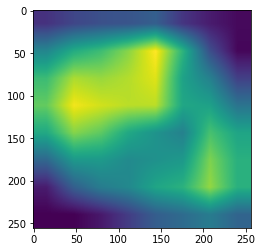

In [72]:

plt.imshow(test[0])


## Datainbalance
This dataset, has lage imbalance where there is 3x as many positive cases as normal. This could be preferable as there would be better to classify a normal as sick then to missclassify someone sick as normal. However if the network is just registering people as sick then we have a problem. Altho the Grad-Cam can visualize what it missclassify. There is a need while to address the data imbalance to futher improve networks accuracy. I propose an Randomized sub-sampeling algorithm that selects from the .

### Algorithm
First assign a uniform random value to each label in the dataset. Then 
load the dataset in chunks of arbitrary size. The chunk loads a subsample of each label, the size of each labels subsamble is determined by the assosiated random value of the label assinged previously.
Finally populate the resulting batch with item from the generated subsamples.


=== todo ===
### Sliding window
### Streaming related stuff.
### Lemma 
